In [2]:
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.decomposition import PCA
# import tensorflow_addons as tfa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Concatenate,Dropout,Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

In [3]:
# Set the working directory
WORKING_DIRECTORY = r"C:\Dataset"

In [4]:
def load_and_preprocess_images(directory, target_size=(160, 160), grayscale=False):
    images = []
    labels = []
    classes = os.listdir(directory)
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if grayscale:
                image = load_img(image_path, target_size=target_size, color_mode='grayscale')
            else:
                image = load_img(image_path, target_size=target_size)
            image_array = img_to_array(image) / 255.0  # Rescale pixel values to [0, 1]
            images.append(image_array)
            labels.append(class_name)
    return np.array(images), np.array(labels)


In [5]:
X, y = load_and_preprocess_images(WORKING_DIRECTORY, grayscale=True)

print("Number of images:", len(X))


Number of images: 554


In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.squeeze(X_train)
X_test = np.squeeze(X_test)
print(X_train.shape)

(443, 160, 160)


In [7]:
def build_denoising_autoencoder(input_dim, encoding_dim):
    # Encoder
    noise=0.5
    input_data = Input(shape=(input_dim,))
    noisy_input = input_data + noise * tf.random.normal(tf.shape(input_data))
    encoded = Dense(128, activation='relu')(noisy_input)
    encoded = Dense(256, activation='relu')(encoded)
    encoded = Dense(encoding_dim, activation='relu')(encoded)
    
    # Decoder
    decoded = Dense(128, activation='relu')(encoded)
    decoded = Dense(512, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)
    
    # Autoencoder
    autoencoder = Model(inputs=input_data, outputs=decoded)
    return autoencoder

In [8]:
# Define input and encoding dimensions
input_dim = 160*160
encoding_dim = 64

In [9]:

# Build the denoising autoencoder
autoencoder = build_denoising_autoencoder(input_dim, encoding_dim)

In [10]:
# Compile the autoencoder with L2 regularization
from tensorflow.keras.optimizers import Adam
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')

In [11]:
# Flatten the input data
train_data_flat = X_train.reshape(X_train.shape[0], -1)
test_data_flat = X_test.reshape(X_test.shape[0], -1)
print(train_data_flat.shape)

(443, 25600)


In [12]:
# Train the denoising autoencoder
autoencoder.fit(train_data_flat, train_data_flat, epochs=100, batch_size=32, shuffle=True, validation_split=0.2)


Epoch 1/100
12/12 [==============================] - 4s 208ms/step - loss: 0.6720 - val_loss: 0.5799
Epoch 2/100
12/12 [==============================] - 2s 176ms/step - loss: 0.4577 - val_loss: 0.3537
Epoch 3/100
12/12 [==============================] - 2s 172ms/step - loss: 0.3289 - val_loss: 0.3204
Epoch 4/100
12/12 [==============================] - 2s 171ms/step - loss: 0.3154 - val_loss: 0.3147
Epoch 5/100
12/12 [==============================] - 2s 160ms/step - loss: 0.3127 - val_loss: 0.3134
Epoch 6/100
12/12 [==============================] - 2s 160ms/step - loss: 0.3112 - val_loss: 0.3125
Epoch 7/100
12/12 [==============================] - 2s 166ms/step - loss: 0.3105 - val_loss: 0.3121
Epoch 8/100
12/12 [==============================] - 2s 164ms/step - loss: 0.3102 - val_loss: 0.3118
Epoch 9/100
12/12 [==============================] - 2s 158ms/step - loss: 0.3098 - val_loss: 0.3115
Epoch 10/100
12/12 [==============================] - 2s 168ms/step - loss: 0.3096 - val_lo

In [13]:
# Get the encoded features
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[-4].output)
encoded_features_train = encoder.predict(train_data_flat)
encoded_features_test = encoder.predict(test_data_flat)
print("encoded_features_train:",encoded_features_train.shape)
print("encoded_features_test:",encoded_features_test.shape)

encoded_features_train: (443, 64)
encoded_features_test: (111, 64)


In [14]:
features_train_reshaped = []
for feature in X_train:
    resized_feature = resize(feature, (229, 229, 3), anti_aliasing=True)
    features_train_reshaped.append(resized_feature)
features_train_reshaped = np.array(features_train_reshaped)

features_test_reshaped = []
for feature in X_test:
    resized_feature = resize(feature, (229, 229, 3), anti_aliasing=True)
    features_test_reshaped.append(resized_feature)
features_test_reshaped = np.array(features_test_reshaped)

In [15]:
# Load pre-trained VGG19 model without the top layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(229, 229, 3))

In [16]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 229, 229, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 229, 229, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 229, 229, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 114, 114, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 114, 114, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 114, 114, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 57, 57, 128)       0     

In [17]:
# Extract features from VGG19
X_train_features = base_model.predict(features_train_reshaped)
X_test_features = base_model.predict(features_test_reshaped)

In [18]:
print(X_train_features.shape)

(443, 7, 7, 512)


In [19]:
# Flatten the extracted features
X_train_features_flat = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_features_flat = X_test_features.reshape(X_test_features.shape[0], -1)

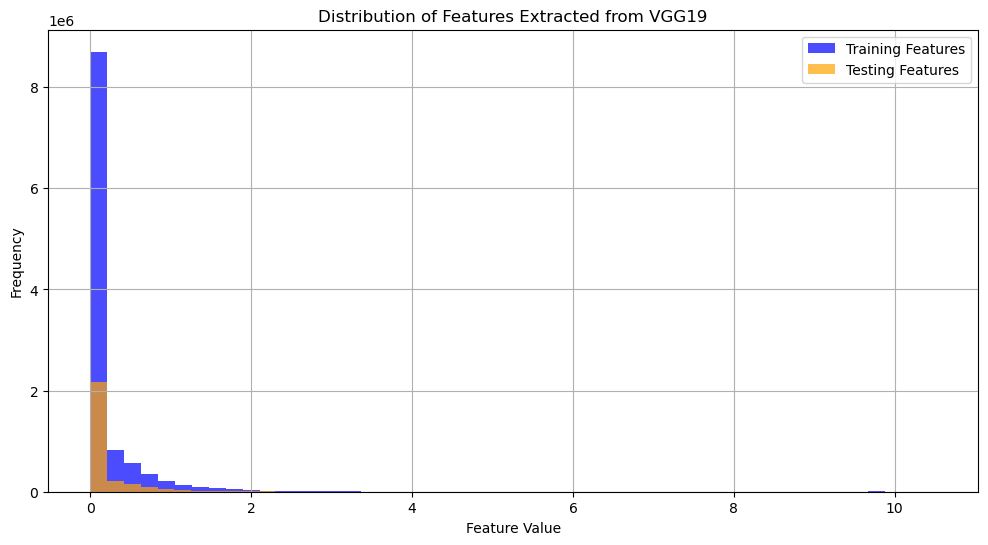

In [20]:
import matplotlib.pyplot as plt

# Plot histograms of the features
plt.figure(figsize=(12, 6))
plt.hist(X_train_features_flat.flatten(), bins=50, alpha=0.7, label='Training Features', color='blue')
plt.hist(X_test_features_flat.flatten(), bins=50, alpha=0.7, label='Testing Features', color='orange')
plt.title('Distribution of Features Extracted from VGG19')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
print("X_train_features:",X_train_features.shape)

X_train_features: (443, 7, 7, 512)


In [22]:
print("Shape of X_train_features_flat:", X_train_features_flat.shape)
print("Shape of encoded_features_train:", encoded_features_train.shape)

Shape of X_train_features_flat: (443, 25088)
Shape of encoded_features_train: (443, 64)


In [23]:
# Combine features from VGG19 and autoencoder
combined_features_train = np.concatenate((X_train_features_flat, encoded_features_train), axis=1)
combined_features_test = np.concatenate((X_test_features_flat, encoded_features_test), axis=1)

In [24]:
print("Combined features shape for training set:", combined_features_train.shape)
print("Combined features shape for testing set:", combined_features_test.shape)

Combined features shape for training set: (443, 25152)
Combined features shape for testing set: (111, 25152)


In [25]:
# Define the number of desired dimensions
n_components = 128

# Initialize PCA with the desired number of components
pca = PCA(n_components=n_components)

# Fit PCA to the combined features
pca.fit(combined_features_train)

# Transform the combined features using PCA
combined_features_train_reduced = pca.transform(combined_features_train)
combined_features_test_reduced = pca.transform(combined_features_test)

In [26]:
print("Shape of combined features after dimensionality reduction (train):", combined_features_train_reduced.shape)
print("Shape of combined features after dimensionality reduction (test):", combined_features_test_reduced.shape)

Shape of combined features after dimensionality reduction (train): (443, 128)
Shape of combined features after dimensionality reduction (test): (111, 128)


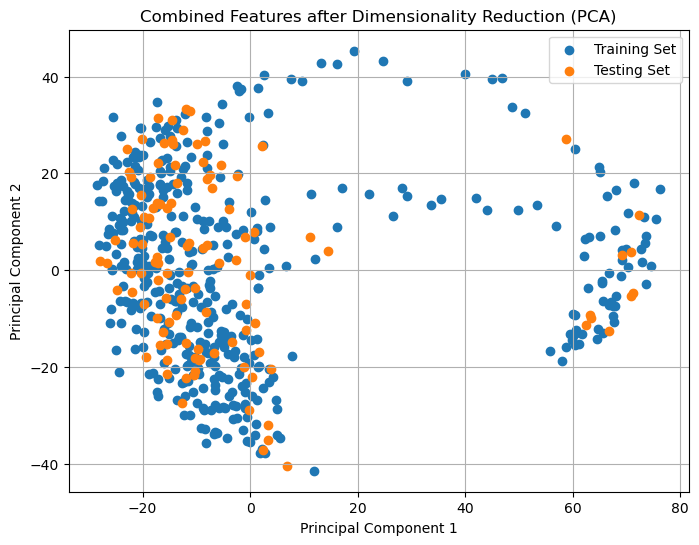

In [27]:
# Create a scatter plot of the combined features
plt.figure(figsize=(8, 6))
plt.scatter(combined_features_train_reduced[:, 0], combined_features_train_reduced[:, 1], label='Training Set')
plt.scatter(combined_features_test_reduced[:, 0], combined_features_test_reduced[:, 1], label='Testing Set')
plt.title('Combined Features after Dimensionality Reduction (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
combined_features_train_reduced_reshaped = combined_features_train_reduced.reshape((-1, 8, 16, 1))
combined_features_test_reduced_reshaped = combined_features_test_reduced.reshape((-1, 8, 16, 1))

input_shape = combined_features_train_reduced_reshaped.shape[1:]
num_classes = 3  # CN, MCI, AD

In [29]:
print("Shape of combined_features_train_reduced_reshaped:", combined_features_train_reduced_reshaped.shape)
print("Input shape for UNet model:", input_shape)

Shape of combined_features_train_reduced_reshaped: (443, 8, 16, 1)
Input shape for UNet model: (8, 16, 1)


In [30]:
def build_multiclass(input_shape):
    inputs = Input(input_shape)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)  # Add dropout after the pooling layer

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.25)(pool2)  # Add dropout after the pooling layer

    flat = Flatten()(pool2)
    dense1 = Dense(256, activation='relu')(flat)
    dense1 = Dropout(0.5)(dense1)  # Add dropout before the output layer

    outputs = Dense(3, activation='softmax')(dense1)  # 3 classes in the output layer

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [31]:
# Build  model for multi-class classification
model_multiclass = build_multiclass(input_shape)

In [32]:
model_multiclass.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 8, 16, 1)]        0         
                                                                 
 conv2d (Conv2D)             (None, 8, 16, 64)         640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 8, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 4, 8, 64)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 8, 128)         73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 4, 128)        0         
 2D)                                                       

In [33]:
# Compile the model
model_multiclass.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train_onehot = tf.keras.utils.to_categorical(y_train_encoded, num_classes=3)
y_test_onehot = tf.keras.utils.to_categorical(y_test_encoded, num_classes=3)

In [35]:
# Train the model
history = model_multiclass.fit(combined_features_train_reduced_reshaped, y_train_onehot, epochs=200, batch_size=16, validation_split=0.2)


Epoch 1/200
23/23 [==============================] - 1s 23ms/step - loss: 1.0850 - accuracy: 0.4520 - val_loss: 0.8776 - val_accuracy: 0.5955
Epoch 2/200
23/23 [==============================] - 0s 11ms/step - loss: 0.9575 - accuracy: 0.5339 - val_loss: 0.8125 - val_accuracy: 0.6404
Epoch 3/200
23/23 [==============================] - 0s 11ms/step - loss: 0.8888 - accuracy: 0.5395 - val_loss: 0.7852 - val_accuracy: 0.5843
Epoch 4/200
23/23 [==============================] - 0s 11ms/step - loss: 0.7999 - accuracy: 0.6356 - val_loss: 0.7398 - val_accuracy: 0.6404
Epoch 5/200
23/23 [==============================] - 0s 11ms/step - loss: 0.7858 - accuracy: 0.6638 - val_loss: 0.7207 - val_accuracy: 0.6854
Epoch 6/200
23/23 [==============================] - 0s 11ms/step - loss: 0.7446 - accuracy: 0.6554 - val_loss: 0.6909 - val_accuracy: 0.7191
Epoch 7/200
23/23 [==============================] - 0s 11ms/step - loss: 0.6799 - accuracy: 0.6977 - val_loss: 0.6687 - val_accuracy: 0.7079
Epoch 

In [36]:
# Evaluate the model on the training and testing sets
# train_loss, train_accuracy = model_multiclass.evaluate(combined_features_train_reduced_reshaped, y_train_onehot)
test_loss, test_accuracy = model_multiclass.evaluate(combined_features_test_reduced_reshaped, y_test_onehot)
print("Testing Accuracy:", test_accuracy)

4/4 [==============================] - 0s 5ms/step - loss: 0.0598 - accuracy: 0.9640
Testing Accuracy: 0.9639639854431152


In [37]:
# print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)


Testing Accuracy: 0.9639639854431152


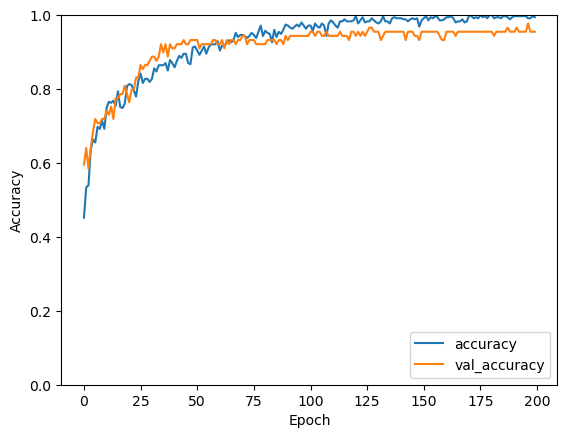

In [38]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [39]:
# Convert test labels to numerical labels
y_test_encoded = label_encoder.transform(y_test)

# Predict probabilities for test data
y_pred_prob = model_multiclass.predict(combined_features_test_reduced_reshaped)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)


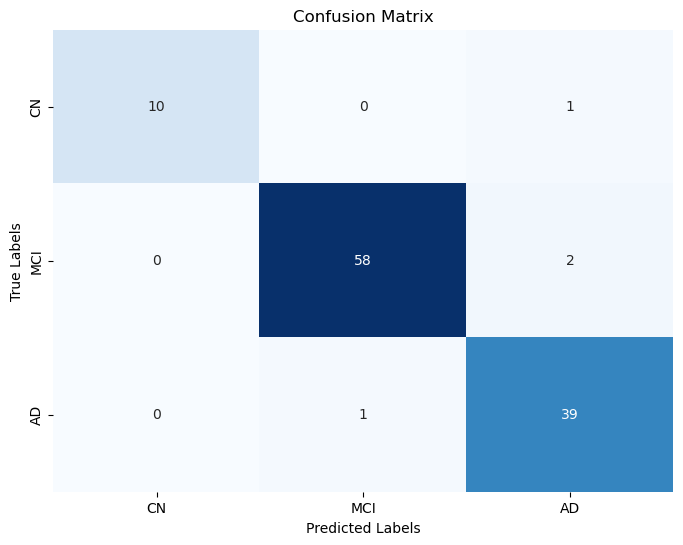

In [40]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['CN', 'MCI', 'AD'], yticklabels=['CN', 'MCI', 'AD'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [41]:
# Classification Report
print(classification_report(y_test_encoded, y_pred, target_names=['CN', 'MCI', 'AD']))


              precision    recall  f1-score   support

          CN       1.00      0.91      0.95        11
         MCI       0.98      0.97      0.97        60
          AD       0.93      0.97      0.95        40

    accuracy                           0.96       111
   macro avg       0.97      0.95      0.96       111
weighted avg       0.97      0.96      0.96       111

